## EXPLORATORY DATA  ANALYSIS

#### Predicting claim frequencies (expected claim count per unit of exposure) expressed as rate. Is the base for key calculations: pricing, reserving, ruin probabilities and reinsurance.

- Import the libraries neccesary for the analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import src.tools as cf

In [165]:
claimsdf = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/ProyectoFinal/Claims-Frequency-Predictions/freMTPL2freq.csv')

#### We'll work on a data set comprising a French motor third-party liability insurance portfolio of 678013 exposure (policies) with corresponding claim counts observed in one accounting year and 12 variables for each policy

In [66]:
claimsdf.head(3)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22


In [4]:
claimsdf.shape

(678013, 12)

In [5]:
claimsdf.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

#### We'll add a colum with the empirical (observed) frequencies for each policy for analysis purpouse

In [172]:
claimsdf['empirical_frequencies'] = (claimsdf.ClaimNb / claimsdf.Exposure)

### CLAIM-NB: Claim counts per policy

#### We'll start with our target variable. Analyzing how the Claims distribute over the portfolio

In [7]:
claims_min = claimsdf.ClaimNb.min()
claims_max = claimsdf.ClaimNb.max()
claims_mean = claimsdf.ClaimNb.mean()
claims_med = claimsdf.ClaimNb.median()
claims_mod = claimsdf.ClaimNb.mode()
claims_min, claims_max, claims_mean, claims_med, claims_mod

(0,
 16,
 0.05324676665491664,
 0.0,
 0    0
 dtype: int64)

In [8]:
claimsdf.ClaimNb[claimsdf.ClaimNb == 0].value_counts()

0    643953
Name: ClaimNb, dtype: int64

In [9]:
claimsdf.ClaimNb[claimsdf.ClaimNb != 0].value_counts()

1     32178
2      1784
3        82
4         7
11        3
5         2
6         1
8         1
16        1
9         1
Name: ClaimNb, dtype: int64

- Almost all claim counts are null, 94.97% of them to be precise.  so we'll have to take this into account when we construct our model, for instance, in a generalized linear model setting we should consider a zero inflated structure.
- For the rest of the portfolio, 4,74% reported 1 claim, 0.26% 2 claims, only 82 policies with 3 claims, and 16 with more than 4 claims. The maximal number of claims is 16 in one year for one policy, wich is most likely an error in the data, and an outlier wich can influence our estimations. As a consequence, we'll set to 4 the claims that are bigger than 4.

In [173]:
def claims_(x):
    """
    arg: A claim count
    returns:if x is bigger than four, returns a four, otherwise, returns the same value
    """
    if x > 4 :
        return 4
    else: 
        return x

In [174]:
claimsdf['ClaimNb'] = claimsdf.ClaimNb.apply(lambda x: claims_(x))

#### !!! AGREGAR DF CON LOS UNIQUE COMO COLUMN Y LOS COUNTS EN LA FILA, Y LA EMP FREQ TOTAL !!!

In [12]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (20.,9.)})
sns.set_style("whitegrid")

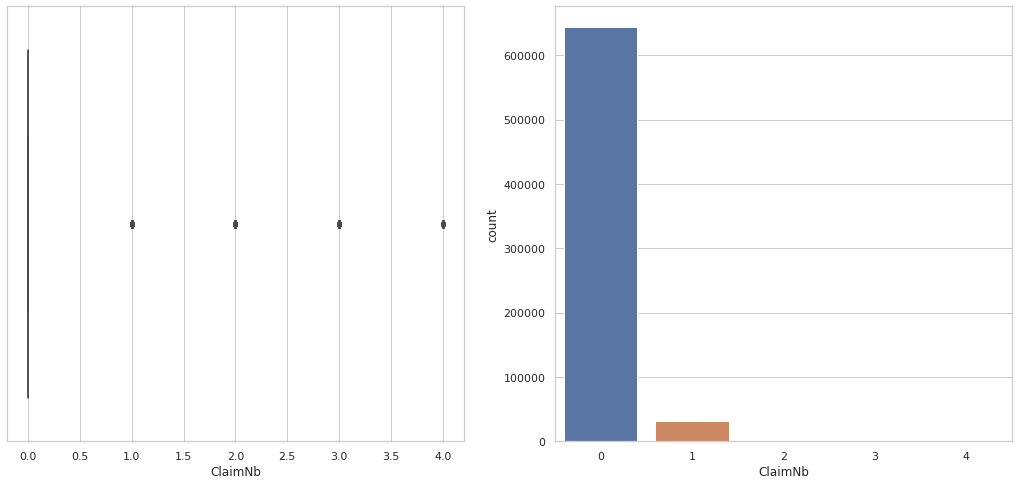

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8)) 
sns.boxplot(x=claimsdf.ClaimNb, ax=axs[0])
sns.countplot(x=claimsdf.ClaimNb, ax=axs[1])
fig.savefig("claims_box_hist.png");

### EXPOSURE: Years at risk, or duration of the policy expressed in years

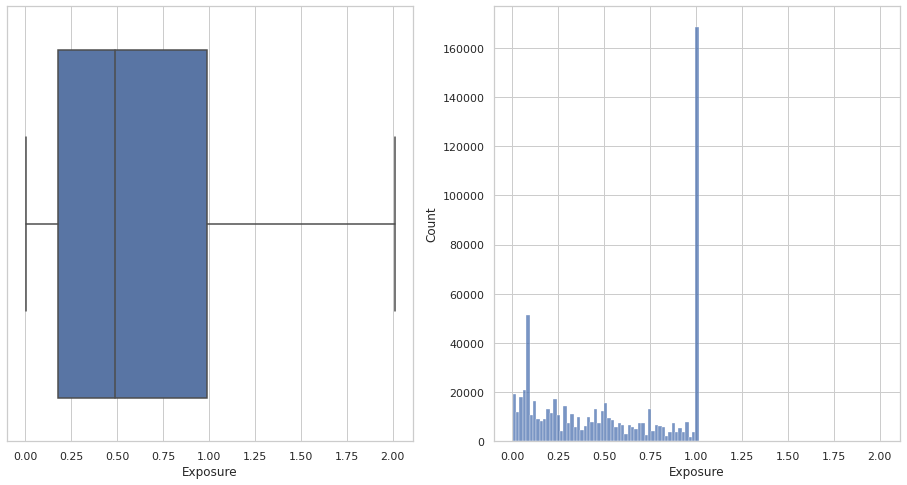

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8)) 
sns.boxplot(x=claimsdf.Exposure, ax=axs[0])
sns.histplot(x=claimsdf.Exposure, ax=axs[1])
fig.savefig("exposure_box_hist.png");

In [15]:
exposure_min = claimsdf.Exposure.min()
exposure_max = claimsdf.Exposure.max()
exposure_mean = claimsdf.Exposure.mean()
exposure_med = claimsdf.Exposure.median()
exposure_mod = claimsdf.Exposure.mode()
exposure_min, exposure_max, exposure_mean, exposure_med, exposure_mod

(0.00273224,
 2.01,
 0.5287501057690319,
 0.49,
 0    1.0
 dtype: float64)

In [16]:
claimsdf.Exposure[claimsdf.Exposure > 1].sum()

1363.34

- The minimal observed time insured in our portfolio is 1 day and the maximal time insured is 2 years. The average time insured is 193 days, the median time insured is 179 days, and only 24,79% of the policies are insured during the whole year.
- As the portfolio is for one accounting year policies, we should consider the exposures bigger than 1 as 1. On the other hand, the policies with bigger than 1 exposures accounts only for the 0.2% of the portfolio

### CATEGORICAL VARIABLES - FEATURE ENGINEERING

- We have 4 categorical variables, and 2 continuous ones, namely Vehicle Age and Driver Age, that we'll categorize in a way such that each resulting class is as homogeneous as possible. 
- We need to encode this cathegorical values for modelling pouposes (dummy-encode for regression structures or simply ordinal values for non parametric modelling like regression tree-style)

#### VEHICLE BRAND: Non ordinal , 11 CLASES

In [17]:
claimsdf.VehBrand.value_counts()

B12    166024
B1     162736
B2     159861
B3      53395
B5      34753
B6      28548
B4      25179
B10     17707
B11     13585
B13     12178
B14      4047
Name: VehBrand, dtype: int64

In [175]:
dic_brands = {'B1': 1, 'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B10': 7, 'B11': 8, 'B12': 9, 'B13': 10, 'B14': 11}

In [176]:
claimsdf.VehBrand = claimsdf.VehBrand.map(dic_brands)

##### VEHICLE GAS: Non ordinal, binary class

- We'll transform this variable to a dummy-variable

In [111]:
claimsdf.VehGas.unique()

array(['Regular', 'Diesel'], dtype=object)

In [113]:
claimsdf.VehGas.value_counts()

Regular    345877
Diesel     332136
Name: VehGas, dtype: int64

In [177]:
claimsdf = pd.get_dummies(claimsdf, columns=['VehGas'], drop_first=True)

##### AREA Code: Ordinal, 6 CLASES

In [23]:
claimsdf.Area.value_counts()

C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64

In [178]:
dic_area = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
claimsdf.Area = claimsdf.Area.map(dic_area)

##### REGION: Non ordinal,  22 CLASSES

- In the data set, we have 22 regions, but after a 2016 reform, some of them fuse, to form 13 regions. We'll update our data set.

In [166]:
regions = ['Île_de_France', 'Champagne_Ardenne', 'Picardie', 'Haute_Normandie', 'Centre', 'Basse_Normandie', 'Bourgogne', 'Nord_Pas-de-Calais', 'Lorraine', 'Alsace', 'Franche_Comté', 'Pays_de_la_Loire', 'Bretagne', 'Poitou_Charentes', 'Aquitaine', 'Midi_Pyrénées', 'Limousin', 'Rhône_Alpes', 'Auvergne', 'Languedoc_Roussillon', 'Provence-Alpes_Côte d´Azur', 'Corse']
regions_code = ['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41', 'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82', 'R83', 'R91', 'R93', 'R94']
for i,j in zip(regions_code, regions):
    claimsdf.Region = claimsdf.Region.str.replace(i, j) 

In [167]:
new_regions = {'Rhône_Alpes': 'Auvergne-Rhône-Alpes',
               'Auvergne': 'Auvergne-Rhône-Alpes',
               'Bourgogne': 'Bourgogne-Franche-Comté',
               'Franche_Comté': 'Bourgogne-Franche-Comté',
               'Centre': 'Centre-Val de Loire',
               'Champagne_Ardenne': 'Grand Est',
               'Lorraine': 'Grand Est',
               'Alsace': 'Grand Est',
               'Nord_Pas-de-Calais': 'Hauts-de-France',
               'Picardie': 'Hauts-de-France',
               'Haute_Normandie': 'Normandie',
               'Basse_Normandie': 'Normandie',
               'Aquitaine': 'Nouvelle-Aquitaine',
               'Limousin': 'Nouvelle-Aquitaine',
               'Poitou_Charentes': 'Nouvelle-Aquitaine',
               'Languedoc_Roussillon': 'Occitanie',
               'Midi_Pyrénées': 'Occitanie',
               'Bretagne': 'Bretagne',
               'Corse': 'Corse',
               'Île_de_France': 'Île-de-France',
               'Pays_de_la_Loire': 'Pays de la Loire',
               'Provence-Alpes_Côte d´Azur':"Provence-Alpes-Côte d'Azur"}

In [168]:
claimsdf['Region'] = claimsdf.Region.map(new_regions)

In [169]:
dic_region = {'Auvergne-Rhône-Alpes': 1, 'Bourgogne-Franche-Comté': 2, 'Centre-Val de Loire': 3, 'Grand Est': 4,
               'Hauts-de-France': 5, 'Normandie': 6, 'Nouvelle-Aquitaine': 7, 'Occitanie': 8, 'Bretagne': 9,
               'Corse': 10, 'Île-de-France': 11, 'Pays de la Loire': 12, "Provence-Alpes-Côte d'Azur": 13}

In [170]:
claimsdf['Region'] = claimsdf.Region.map(dic_region)

#### VEHICLE POWER: Ordered cathegorical according to the data source

- We have 12 Vehicle Power classes, but we'll keep only 9, and group four of them in one class for homogeneity reasons.

In [179]:
def vehpower_gr(x):
    """
    ARG: A number
    Returns: If is different from 12, 13, 14 or 15, returns the number, 
    otherwise, returns 12
    """
    if x in [12, 13, 14, 15]:
        x_ = 12
        return x_
    else:
        return x

In [180]:
claimsdf['VehPower_'] = claimsdf.VehPower.apply(lambda x: vehpower_gr(x))

In [131]:
veh_power = pd.DataFrame(claimsdf.VehPower_.value_counts())
veh_power

,VehPower_
6,148976
7,145401
5,124821
4,115349
8,46956
10,31354
9,30085
11,18352
12,16719


#### VEHICLE AGE

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


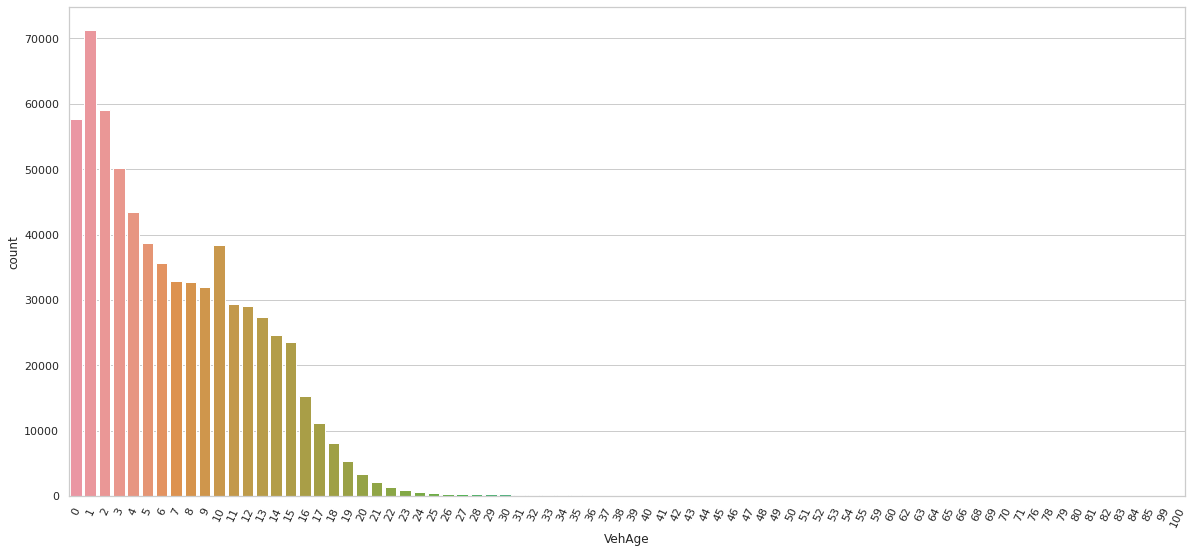

In [35]:
ax = sns.countplot(claimsdf['VehAge'])
ax.tick_params(axis='x', rotation=65)
fig.savefig("vehage_countplot.png");

- As we can see in the above graph, almost all cars in the data set are under 20 years old, we will group them in 3 different classes 

In [181]:
def vehage_gr(x):
    """
    ARG: A number
    Returns: If x belongs to [0,1] -> 1
             If x belongs to (1,10] -> 2
             If x belongs to (10,+inf) -> 3
    """
    if x in range(2):
        x_ = 1
        return x_
    elif x in range(1,11):
        x_ = 2
        return x_
    else:
        return 3

In [182]:
claimsdf['VehAge_'] = claimsdf.VehAge.apply(lambda x: vehage_gr(x))

In [135]:
veh_age = pd.DataFrame(claimsdf.VehAge_.value_counts())
veh_age

,VehAge_
2,363208
3,185782
1,129023


#### DRIVER AGE

- We'll use the same criteria for the drivers age, by grouping them in 8 different clases 

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


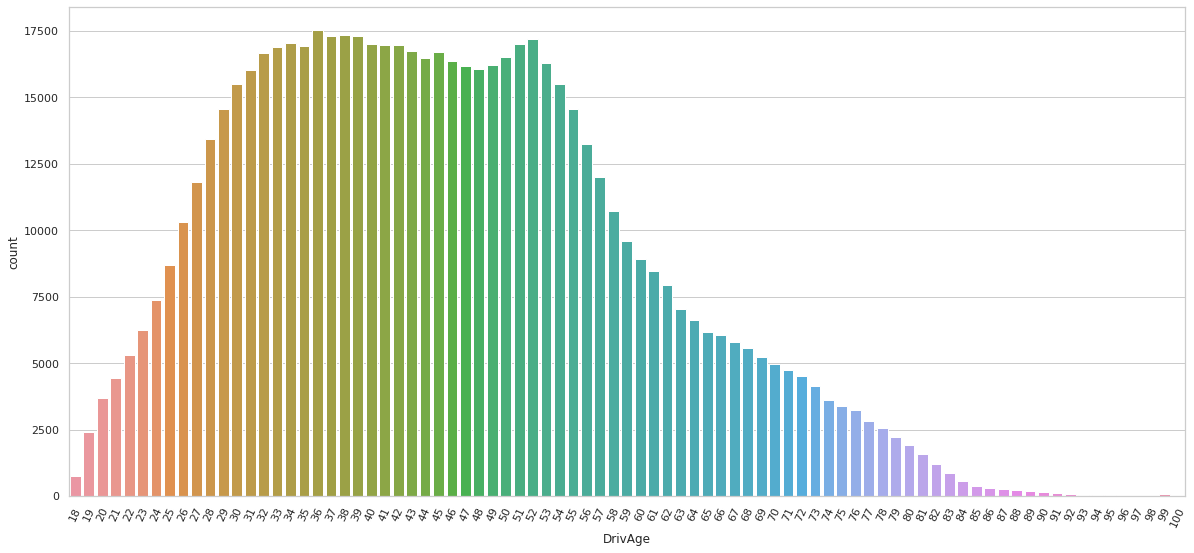

In [39]:
ax = sns.countplot(claimsdf.DrivAge)
ax.tick_params(axis='x', rotation=65)
fig.savefig("drivage_countplot.png");

In [183]:
def drivage_gr(x):
    """
    ARG: A number
    Returns: Assings a class (from 1 to 8) if x belongs to the specified ranges
    """
    if x in range(18,21):
        x_ = 1
        return x_
    elif x in range(21,26):
        x_ = 2
        return x_
    elif x in range(26,31):
        x_ = 3
        return x_
    elif x in range(31,41):
        x_ = 4
        return x_
    elif x in range(41,51):
        x_ = 5
        return x_
    elif x in range(51,61):
        x_ = 6
        return x_
    elif x in range(61,71):
        x_ = 7
        return x_

    else:
        return 8

In [184]:
claimsdf['DrivAge_'] = claimsdf.DrivAge.apply(lambda x: drivage_gr(x))

In [140]:
drivers_age = pd.DataFrame(claimsdf.DrivAge_.value_counts())
drivers_age

,DrivAge_
4,170097
5,165185
6,135014
3,65594
7,63863
8,39365
2,32079
1,6816


- Now, we just keep the new transformed columns, and drop the ID of the policies because it makes no sense as an explanatory variable to predict the frequency of claims.

In [185]:
claimsdf.drop(columns=['IDpol', 'VehPower', 'VehAge', 'DrivAge'], inplace=True)

### CONTINUOUS VARIABLES

#### DENSITY

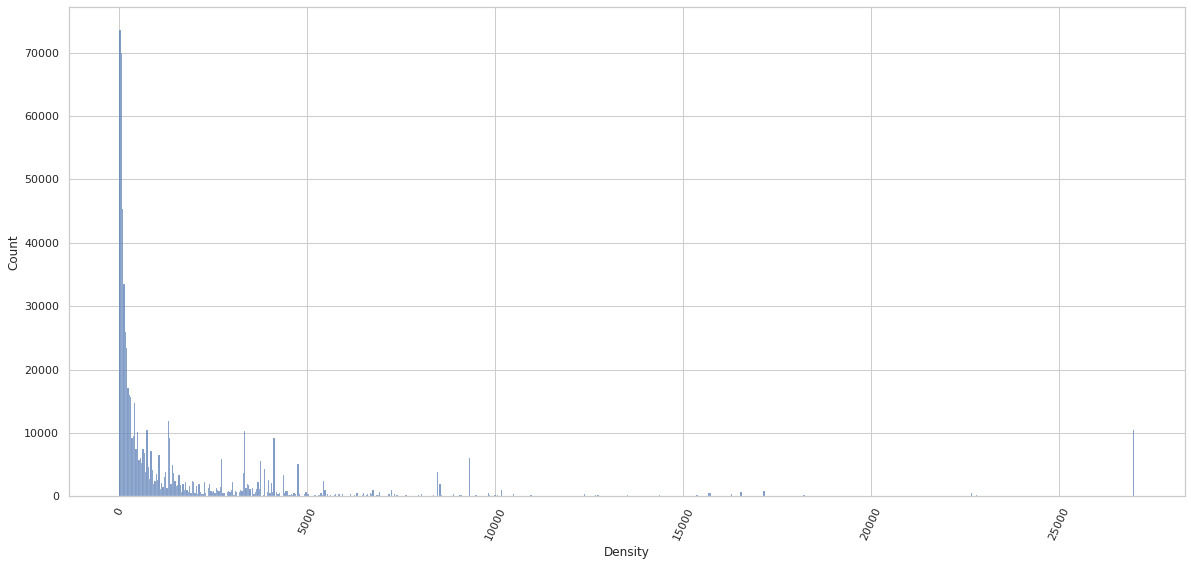

In [44]:
ax = sns.histplot(claimsdf['Density'])
ax.tick_params(axis='x', rotation=65)
fig.savefig("density_hist.png");

- We'll treat the density in a logarithmic scale

In [186]:
claimsdf['log_density'] = np.log(claimsdf.Density) 
claimsdf.drop(columns="Density", inplace=True)

#### BONUSMALUS (goes from 50 to 350)

- This is a score for the insured policy, its range is form 50 to 350, the smaller the score, the better driver, and it performs discounts on primes

In [46]:
claimsdf.BonusMalus.value_counts()

50     384156
100     19530
68      18791
72      18580
76      18226
        ...  
135         1
136         1
230         1
208         1
151         1
Name: BonusMalus, Length: 115, dtype: int64

## FREQUENCIES vs FEATURE COMPONENTS

#### We'll start a visual exploration of our portfolio structure in terms of exposures and observed frequencies for each of the components.

#### AREA CODES

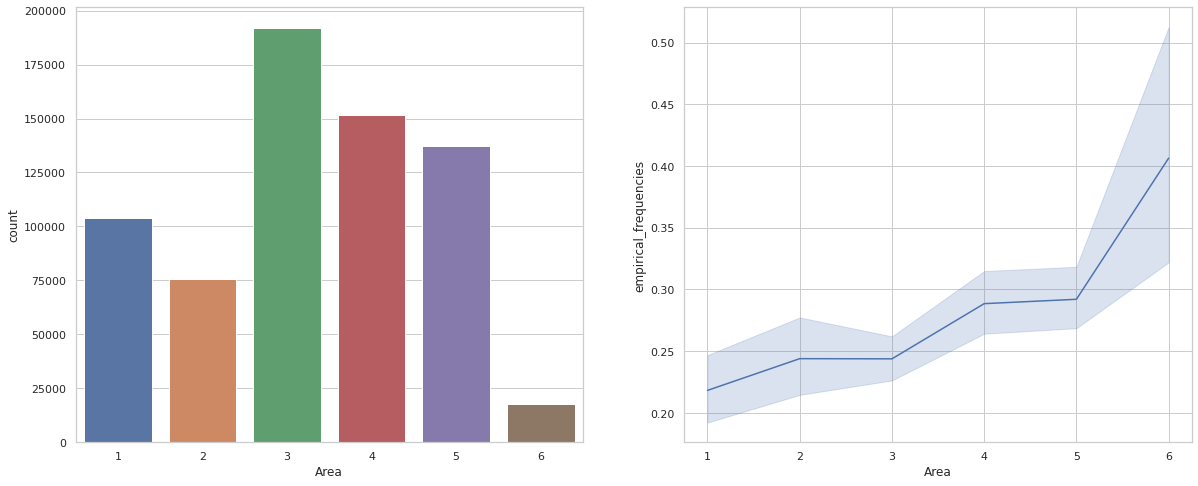

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.countplot(x=claimsdf.Area, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.Area, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("area_codes.png");

- We can see an increasing observed frequency for the area code, suggesting that there's some sense of ordinality in this feature.

#### REGIONS AND POBLATIONAL DENSITY

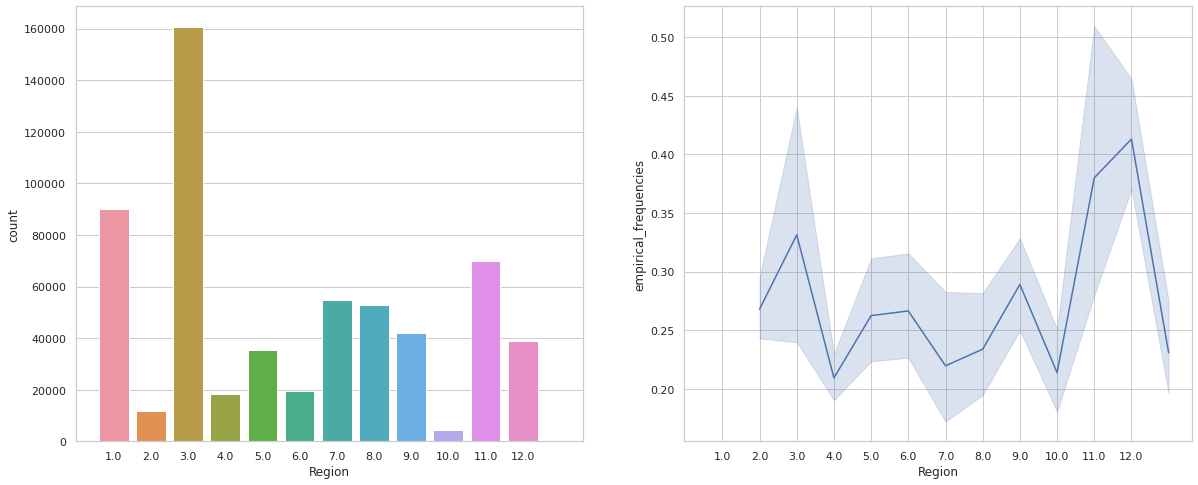

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 8))
sns.countplot(x=claimsdf.Region, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.Region, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("region_counts_empfreq.png");

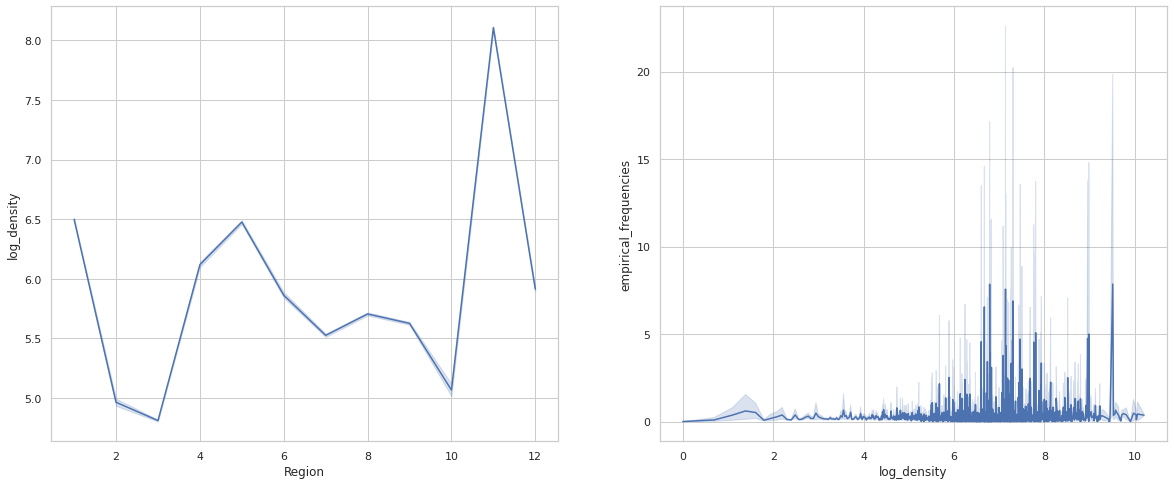

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.lineplot(data=claimsdf, x=claimsdf.Region, y=claimsdf.log_density, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.log_density, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("region_logdens.png");

- We can see that the biggest volume corresponds to the in Centre-Val de Loire region, but if we look at the population density, it is bigger for the Île-de-France regions, that includes Paris. We can observe also that the frequencies are higher for that region. 
- The variability of the frequencies with respect to the regions maybe reflects differences in population densities. We can see that, althoughnot very clearly that the frequencies seems to go up in concordance with population density.

#### VEHICLE GAS TYPE

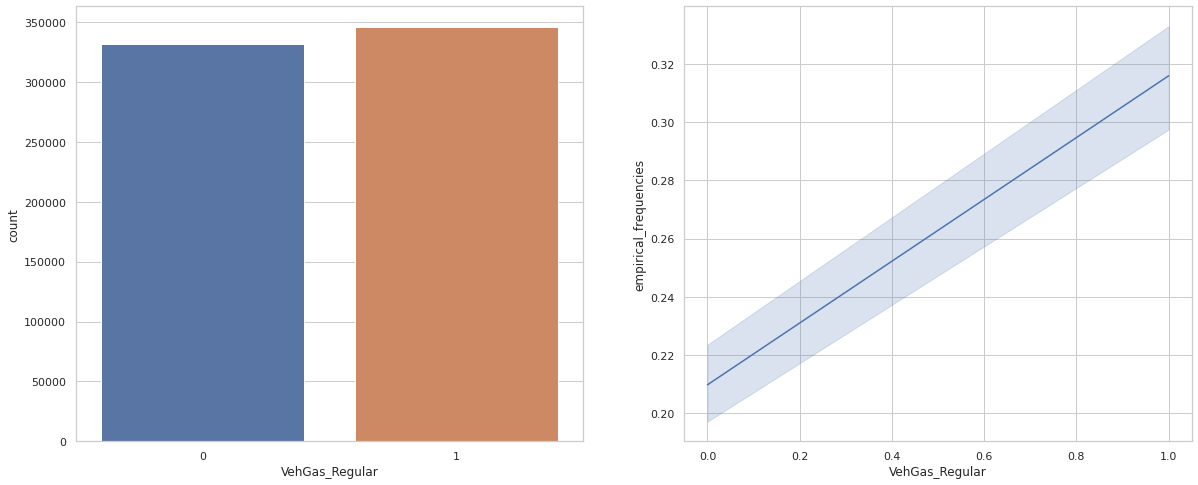

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.countplot(x=claimsdf.VehGas_Regular, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehGas_Regular, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("gas_counts_empfreq.png");

#### VEHICLE POWER

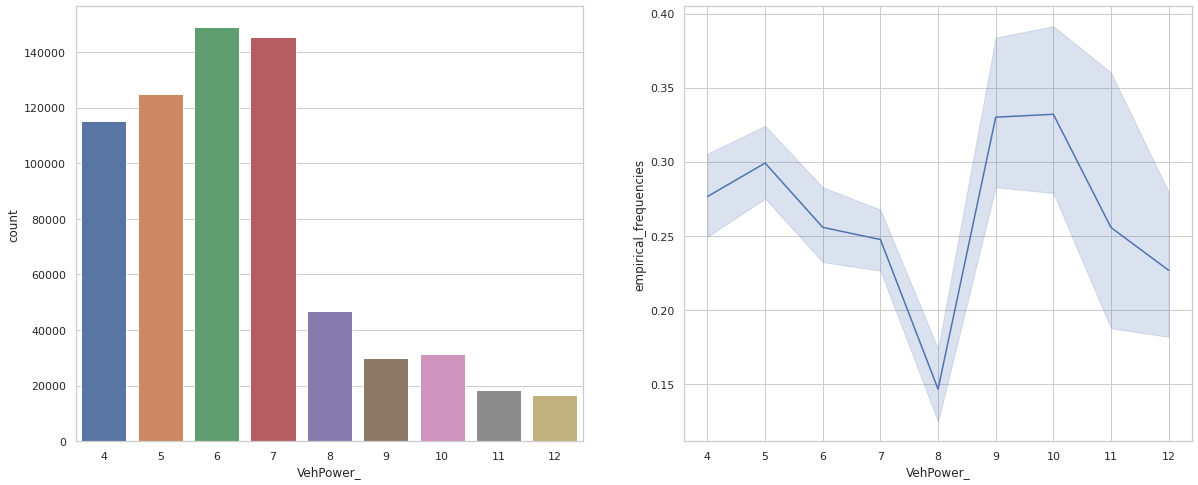

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.countplot(x=claimsdf.VehPower_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehPower_, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("power_counts_empfreq.png");

- The observed frequency for vehicle power doesn't show a clear trend. The highest frequencies are reach for vehicles with power 5, 9 and 10, with a notorious decrease for 8 power vehicles.

#### VEHICLE AGE 

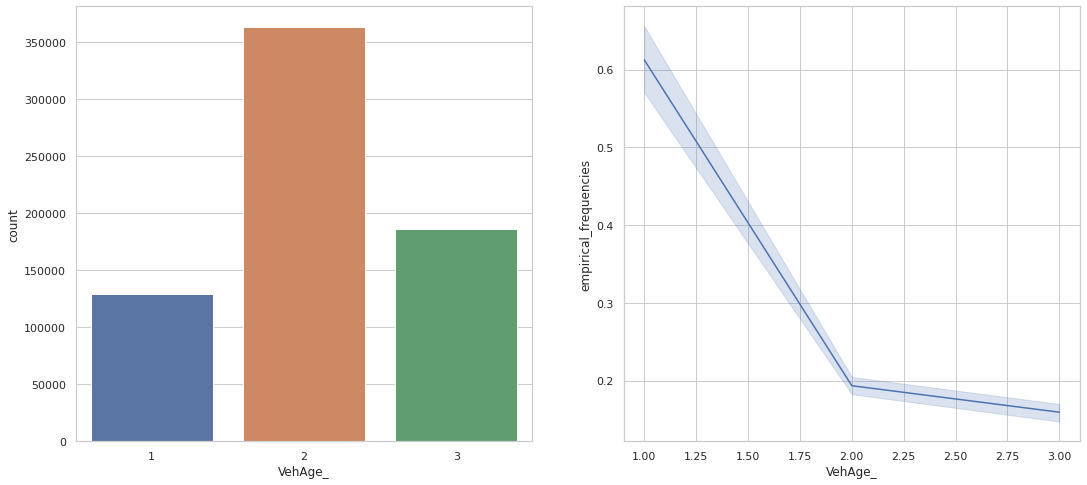

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.VehAge_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehAge_, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("vehage_counts_empfreq.png");

- Most of the policies are of 1 to 10 years old and the empirical frequency it seems to be decreasing in vehicle age, but we have to keep in mind that most policies are for "younger cars" and probably account for mor frequency because of the size.

#### VEHICLE BRAND 

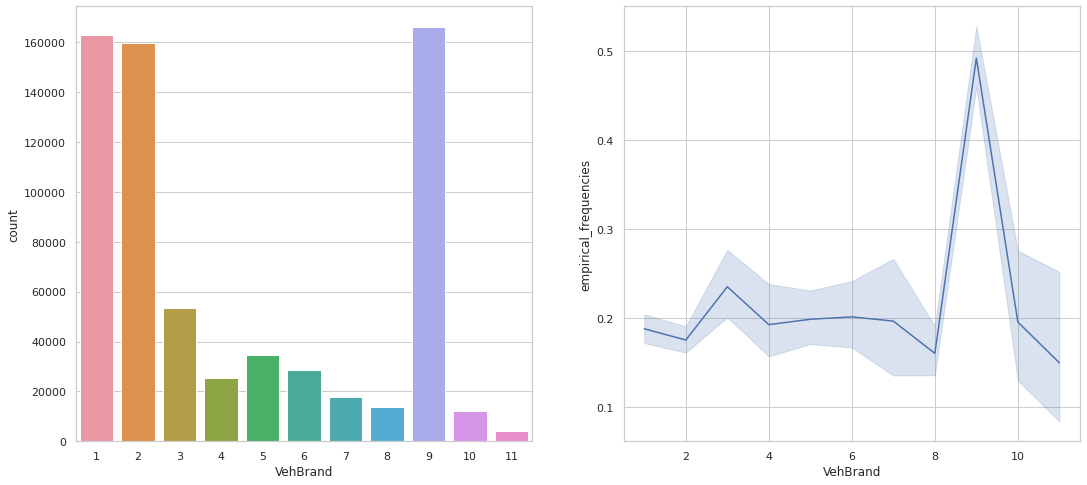

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.VehBrand, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehBrand, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("vehbrand_counts_empfreq.png");

- As we can see, we have big volumes in car brands 1, 2 and 9 (B1, B2, B11). But most of the observed frequencies seems to belong to the B11 brand.

#### DRIVERS AGE

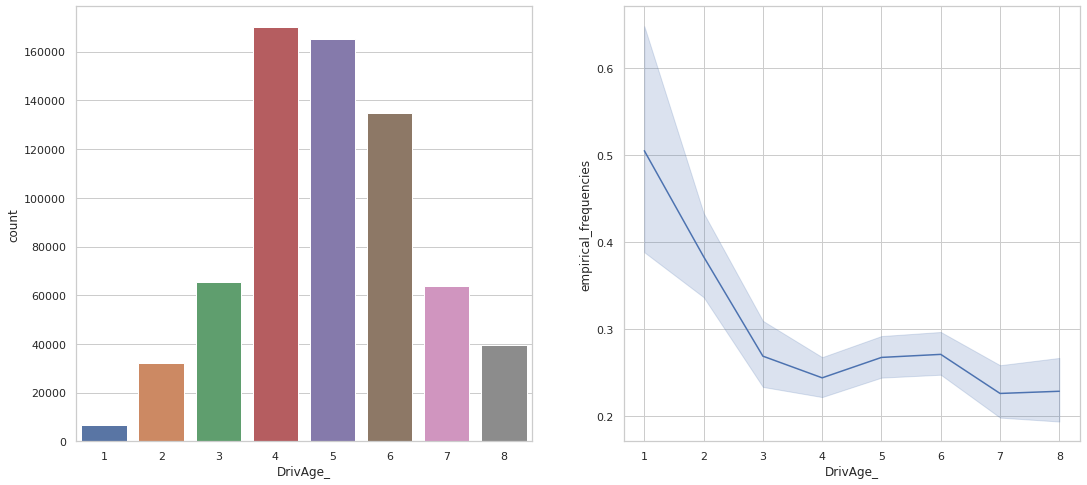

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.DrivAge_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.DrivAge_, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("drivage_counts_empfreq.png");

- Most of the drivers age in the portfolio are between 31 and 61. There's a pronounced decrease in the observed frequency between 18 and 31 and then a slightly increase between 41 to 61 years old drivers.

#### BONUS MALUS

In [187]:
def bonusmalus_gr(x):
    """
    ARG: A number
    Returns: Assings a class (from 1 to 7) if x belongs to the specified ranges
    """
    if x in range(50, 61):
        x_ = 1
        return x_
    elif x in range(61,71):
        x_ = 2
        return x_
    elif x in range(71,81):
        x_ = 3
        return x_
    elif x in range(81,91):
        x_ = 4
        return x_
    elif x in range(91,101):
        x_ = 5
        return x_
    elif x in range(101,151):
        x_ = 6
        return x_
    else:
        x_ = 7
        return x_

In [188]:
claimsdf['BonusMalus_'] = claimsdf.BonusMalus.apply(lambda x: bonusmalus_gr(x))

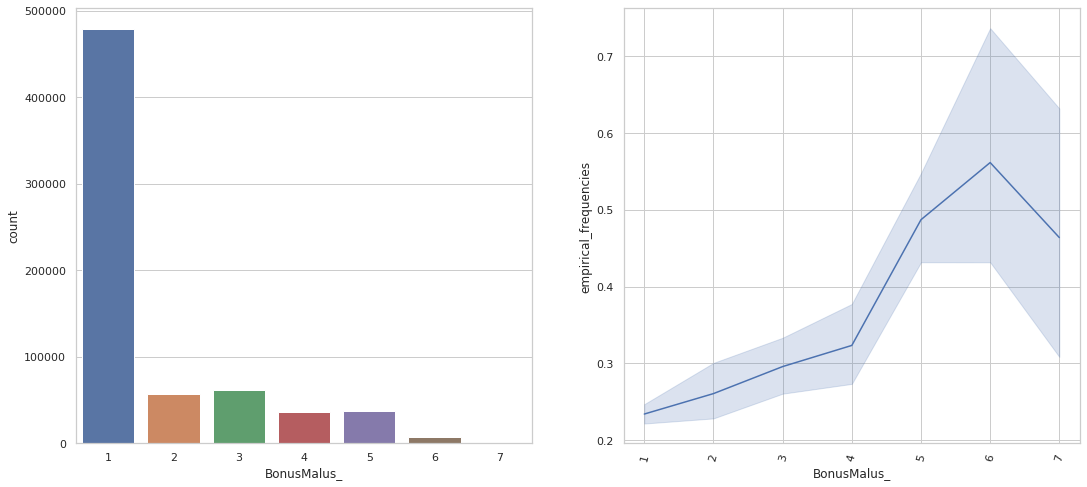

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.BonusMalus_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.BonusMalus_, y=claimsdf.empirical_frequencies, ax=axs[1])
plt.xticks(rotation=75)
fig.savefig("bonusmalus_counts_empfreq.png");

- It's clear by the countplot that most of the exposures have good scores "Bouns"The Bonus Malus score seems to have a clear trend with respect to the observed frequency. It makes sense that better scores accounts for smaller frequencies.  

In [189]:
claimsdf.drop(columns='BonusMalus_', inplace=True)

## CORRELATION ANALYSIS 

### CORRELATION MATRIX

In [162]:
correlations = claimsdf.corr()
correlations

,ClaimNb,Exposure,Area,BonusMalus,VehBrand,Region,empirical_frequencies,VehGas_Regular,VehPower_,VehAge_,DrivAge_,log_density
ClaimNb,1.000000,0.069681,0.013599,0.051182,-0.000786,-0.007260,0.256159,0.012680,-0.003759,-0.023679,0.006929,0.014449
Exposure,0.069681,1.000000,-0.121939,-0.183018,-0.195107,-0.114707,-0.051561,0.040123,-0.044995,0.172323,0.167255,-0.122206
Area,0.013599,-0.121939,1.000000,0.120858,0.124997,0.258127,0.006991,0.128465,0.000039,-0.099175,-0.042675,0.970618
BonusMalus,0.051182,-0.183018,0.120858,1.000000,-0.029410,0.005562,0.013806,0.031422,-0.077181,0.068867,-0.513732,0.125258
VehBrand,-0.000786,-0.195107,0.124997,-0.029410,1.000000,0.178798,0.022725,0.026959,0.204588,-0.373299,0.055749,0.125843
Region,-0.007260,-0.114707,0.258127,0.005562,0.178798,1.000000,0.005511,0.038326,0.019725,-0.128755,0.022150,0.251199
empirical_frequencies,0.256159,-0.051561,0.006991,0.013806,0.022725,0.005511,1.000000,0.011555,-0.001749,-0.030569,-0.004933,0.007219
VehGas_Regular,0.012680,0.040123,0.128465,0.031422,0.026959,0.038326,0.011555,1.000000,-0.069328,0.115424,0.057778,0.131163
VehPower_,-0.003759,-0.044995,0.000039,-0.077181,0.204588,0.019725,-0.001749,-0.069328,1.000000,-0.023736,0.040675,0.001647
VehAge_,-0.023679,0.172323,-0.099175,0.068867,-0.373299,-0.128755,-0.030569,0.115424,-0.023736,1.000000,-0.061029,-0.099008


### HEAT MAP

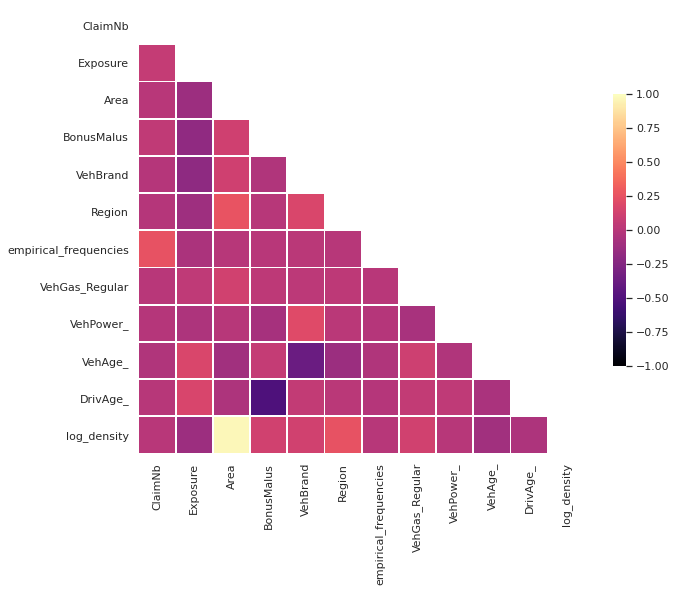

In [164]:
fig, ax = plt.subplots(figsize=(10,10)) 
mask = np.triu(np.ones_like(correlations, dtype=bool))
color_map = sns.diverging_palette(0, 10, as_cmap=True) 
sns.heatmap(correlations, 
            cmap="magma",
            mask=mask,
            vmax=1,
            vmin=-1,
            square=True, 
            linewidth=.8, 
            cbar_kws={"shrink": .5},
            ax=ax
)
fig.savefig("correlations.png");

- From a first view, we can see a strong strong positive colinearity between the area code and the density of the population, wich indicates that the bigger the population density, the bigger the area code. Let's recall for example that area code 6 it accounts only for Ile de France. We can also check for slightly positive correlation with Region.
- There's a negative relation between the Bonus Malus and the Driver age, wich can be observed if one compares their respective frequency graphs. A slighlty positive realation with population density and vehicle age (the younger the car the smaller the bonusmalus), and a negative relation with vehicle power. 
- There's a negative realtion between vehicle age and the vehicle power. And also with drivers age.

- Now, we proceed to export a csv file with the cleaned data frame for modelling

In [190]:
claimsdf.to_csv('claimsdf_1.csv', index = False)